In [1]:
import psycopg2

In [2]:
# set-up a postgres connection
conn = psycopg2.connect(database='ng', user='ngadmin',password='stonebra',
                            host='146.148.89.5', port=5432)
dbcur = conn.cursor()
print("connection successful")

connection successful


In [ ]:
sql = dbcur.mogrify("""
WITH 
    video_record AS(
        select 
            dp.vid,
            vr.video_record_id as vrid, vr.time as time, dp.frame_num as frm, 
            dp.head_color as hc, 
            dp.upper_body_color as ubc, 
            dp.bottom_body_color as bbc,
            dp.gender
        from 
            video_record as vr
        JOIN 
            detected_people as dp
        ON 
            vr.video_record_id = dp.video_record_id
        JOIN 
            location_record as lr
        ON 
            vr.video_record_id = lr.video_record_id
        ORDER BY 
            vr.video_record_id, dp.frame_num
        /* LIMIT 20 */
    ),
    incident_record AS(
        select 
            irr.incident_report_id as iid,
            irr.incident_report_id_v4 as irrid, 
            irr.incident_date + irr.incident_time,
            null, 
            detected_people.head_color as hc,
            detected_people.upper_body_color as ubc,
            detected_people.bottom_body_color as bbc,
            detected_people.gender as g
        from 
            incident_report_record as irr
        JOIN 
            incident_report_detected_people as detected_people
        ON 
            irr.incident_report_id = detected_people.incident_report_id
        /* 
            Following erases the rows which have none of the color codes
            That kind of report will match with all frames, so no need
        */
        AND
            (
                array_length(detected_people.head_color, 1) is not null OR
                array_length(detected_people.upper_body_color, 1) is not null OR
                array_length(detected_people.bottom_body_color, 1) is not null
            )
    )
    
SELECT 
    A.vid, B.vid,
    (CASE WHEN A.ubc=B.ubc THEN 0
                ELSE 1
           END) + 
    (CASE WHEN A.hc=B.hc THEN 0
                ELSE 1
           END) + 
    (CASE WHEN A.bbc=B.bbc THEN 0
                ELSE 1
           END)
    AS ED
FROM video_record A
JOIN video_record B 
ON 
    A.vid != B.vid
    AND 
    A.frm != B.frm
    
UNION

SELECT 
    B.vid, A.iid, 
    /* no need of next line as filtered out the rows with all null color */
    /* CASE WHEN (array_length(A.bbc, 1) is null and array_length(A.ubc, 1) is null and array_length(A.hc, 1) is null) THEN 100
        ELSE
    */
    (CASE WHEN lower(B.bbc) ILIKE ANY(A.bbc) THEN 0
            WHEN (array_length(A.bbc, 1) is null and B.bbc is null) THEN 0
            WHEN array_length(A.bbc, 1) is null THEN 1
                ELSE array_length(A.bbc, 1)
           END) +
    (CASE WHEN lower(B.ubc) ILIKE ANY(A.ubc) THEN 0
            WHEN (array_length(A.ubc, 1) is null and B.ubc is null) THEN 0
            WHEN array_length(A.bbc, 1) is null THEN 1
                ELSE array_length(A.bbc, 1)
           END) +
    (CASE WHEN lower(B.hc) ILIKE ANY(A.hc) THEN 0
            WHEN (array_length(A.hc, 1) is null and B.hc is null) THEN 0
            WHEN array_length(A.bbc, 1) is null THEN 1
                ELSE array_length(A.bbc, 1)
           END) + 
    /* video records dont have gender, so always +1 to add it */
    1 
    /* END */
    AS ED
FROM incident_record A
JOIN video_record B
ON
    A.irrid != B.vrid
;
""")
    
dbcur.execute(sql)
data = dbcur.fetchall()
leng = 0
print(len(data))
# for row in data:
#     leng+=1
#     print(row)
# print(leng)

In [ ]:
sql = dbcur.mogrify("""
WITH 
    incident_record AS(
        select 
            irr.incident_report_id as iid,
            irr.incident_report_id_v4 as irrid, 
            irr.incident_date + irr.incident_time,
            null, 
            detected_people.head_color as hc,
            detected_people.upper_body_color as ubc,
            detected_people.bottom_body_color as bbc,
            detected_people.gender as g
        from 
            incident_report_record as irr
        JOIN 
            incident_report_detected_people as detected_people
        ON 
            irr.incident_report_id = detected_people.incident_report_id
        /* 
            Following erases the rows which have none of the color codes
            That kind of report will match with all frames, so no need
        */
        AND
            (
                array_length(detected_people.head_color, 1) is not null OR
                array_length(detected_people.upper_body_color, 1) is not null OR
                array_length(detected_people.bottom_body_color, 1) is not null
            )
    )
    
SELECT
    A.iid, B.iid, A.g, B.g, lower(A.ubc::text)::text[], lower(B.ubc::text)::text[], 
    lower(A.hc::text)::text[], lower(B.hc::text)::text[], 
    lower(A.bbc::text)::text[], lower(B.bbc::text)::text[]
FROM incident_record A
JOIN incident_record B 
ON
A.irrid != B.irrid
;
""")
    
dbcur.execute(sql)
data = dbcur.fetchall()
leng = 0
result = []
leng = 0
for row in data:
    #leng+=1
    result.append(
        (
          2, row[0], row[1], 
          editDistDP(row[4], row[5], len(row[4]), len(row[5])) +
          editDistDP(row[6], row[7], len(row[6]), len(row[7])) +
          editDistDP(row[8], row[9], len(row[8]), len(row[9])) + 
          (1 if row[2] != row[3] else 0)
         )
    )
print(len(result))

In [ ]:
# sql = dbcur.mogrify("""
#sqlstr = 'INSERT INTO content_edit_distance_realistic (ced_type, uid1, uid2, distance) VALUES'
# sqlstr += result[0]
# sqlstr += " ON CONFLICT DO NOTHING RETURNING id;"
# print(result[0])
for item in result:
    sql = dbcur.mogrify('INSERT INTO content_edit_distance_realistic (ced_type, uid1, uid2, distance) VALUES (%s, %s, %s, %s) ON CONFLICT DO NOTHING RETURNING ced_id', item)
    dbcur.execute(sql)
    #data = dbcur.fetchall()
    #for row in data:
    #    print(row)
        
conn.commit()

In [ ]:
#####

In [ ]:
sql = dbcur.mogrify("""
select A.vrid, A.frm, B.vrid, B.frm,
(CASE WHEN A.ubc=B.ubc THEN 0
            ELSE 1
       END) + 
(CASE WHEN A.hc=B.hc THEN 0
            ELSE 1
       END) + 
(CASE WHEN A.bbc=B.bbc THEN 0
            ELSE 1
       END)
from
(select vr.video_record_id as vrid, vr.time as time, dp.frame_num as frm, 
dp.head_color as hc, 
dp.upper_body_color as ubc, 
dp.bottom_body_color as bbc,
dp.gender
from video_record as vr
JOIN detected_people as dp
ON vr.video_record_id = dp.video_record_id) as B
JOIN
(select vr.video_record_id as vrid, vr.time as time, dp.frame_num as frm, 
dp.head_color as hc, 
dp.upper_body_color as ubc, 
dp.bottom_body_color as bbc,
dp.gender
from video_record as vr
JOIN detected_people as dp
ON vr.video_record_id = dp.video_record_id
JOIN location_record as lr
ON vr.video_record_id = lr.video_record_id
order by vr.video_record_id, dp.frame_num) as A
ON A.vrid != B.vrid
limit 100
;
    """)
#GROUP BY vr.video_record_id, vr.link, vr.time, lr.location, lr.address;
#UNION
    
dbcur.execute(sql)


In [ ]:
data = dbcur.fetchall()

In [ ]:
leng = 0
for row in data:
    #leng+=1
    print(row)
print(leng)

In [ ]:
# Works
sql = dbcur.mogrify("""
    set seed to 0.1234; /* seed (-1 .. 1) */
    WITH 
        video_record AS(
            select 
                dp.vid,
                vr.video_record_id as vrid, vr.time as time, dp.frame_num as frm, 
                dp.head_color as hc, 
                dp.upper_body_color as ubc, 
                dp.bottom_body_color as bbc,
                dp.gender
            from 
                video_record as vr
            JOIN 
                detected_people as dp
            ON 
                vr.video_record_id = dp.video_record_id
            JOIN 
                location_record as lr
            ON 
                vr.video_record_id = lr.video_record_id
            AND 
                vr.time >= '2019-11-14'::date and vr.time <= '2019-12-16'::date 
            ORDER BY RANDOM()
            LIMIT 1450
            /*
            ORDER BY 
                vr.video_record_id, dp.frame_num
            LIMIT 20 
            */
        )
        
    SELECT
        vrid, frm, hc, ubc, bbc, vid 
    FROM
        video_record
    """)
#GROUP BY vr.video_record_id, vr.link, vr.time, lr.location, lr.address;
#UNION
    
dbcur.execute(sql)
data = dbcur.fetchall()

color = dict()
for row in data:
    temp = row[2]
    if temp.lower() not in color:
        color[temp.lower()] = 1
    else:
        color[temp.lower()] += 1
    
    temp = row[3]
    if temp.lower() not in color:
        color[temp.lower()] = 1
    else:
        color[temp.lower()] += 1
        
    temp = row[4]
    if temp.lower() not in color:
        color[temp.lower()] = 1
    else:
        color[temp.lower()] += 1
print(color)

In [ ]:
# Works
import networkx as nx
graphs = dict()
gid = 0

for row in data:
    node_id = 0 
    G = nx.DiGraph()
    G.add_node(0, label=0)
    node_id+=1
    
    G.add_node(node_id, label=1) # type - name of Entity
    G.add_edge(0, node_id, label=0) # label=0 is hasEntity
    node_id+=1
    G.add_node(node_id, label=2) # type - entityType
    G.add_edge(node_id-1, node_id, label=1) # entityType
    node_id+=1
    
    G.add_node(node_id, label=color[row[2].lower()]) # type - color
    G.add_edge(1, node_id, label=2) # head_color
    node_id+=1
    G.add_node(node_id, label=color[row[3].lower()])
    G.add_edge(1, node_id, label=3) # ubc
    node_id+=1
    G.add_node(node_id, label=color[row[4].lower()] )
    G.add_edge(1, node_id, label=4) # lbc
    node_id+=1
    
    G.graph['gid'] = gid
    graphs[row[5]] = G
    gid += 1

In [ ]:
import networkx as nx
graphs = []
seen_attributes = set()
gid = 0
first = 0

G = nx.DiGraph()
node_id = 0 
for row in data:
    print(seen_attributes)
    # print(row) 
    # if-else; if frame is not None
    if (row[0], row[1]) not in seen_attributes:
        if len(seen_attributes) != 0:
            print(G.nodes(data=True))
            print(G.edges(data=True))
            input("wait")
            G.graph['gid'] = gid
            graphs.append(G)
            gid += 1
        node_id = 0 
        G = nx.DiGraph()
        G.add_node(0, type=0, name='Content', conent_type='Video Frame', frame_number=row[2], 
               video_id=row[0], uid=row[] label=node_id)
        node_id+=1
        seen_attributes.add((row[0], row[2]))
    # if-else done
    G.add_node(node_id, type=1, name='Suspect', label=node_id) # type - name of Entity
    G.add_edge(0, node_id, label=0) # label=0 is hasEntity
    node_id+=1
    G.add_node(node_id, type=2, name='Person', label=node_id) # type - entityType
    G.add_edge(node_id-1, node_id, label=1) # entityType
    node_id+=1
    ###
    G.add_node(node_id, type=3, name=row[3].lower(), label=node_id) # type - color
    G.add_edge(1, node_id, label=2) # head_color
    node_id+=1
    G.add_node(node_id, type=3, name=row[4].lower(), label=node_id)
    G.add_edge(1, node_id, label=3) # ubc
    node_id+=1
    G.add_node(node_id, type=3, name=row[5].lower(), label=node_id)
    G.add_edge(1, node_id, label=4) # lbc
    node_id+=1
    #G.add_node(node_id, type=4, name=row[6], label=node_id) # type = gender
    #G.add_edge(1, node_id, label=5) # gender
    #node_id+=1
    
    #print(G.nodes(data=True))
    #print(G.edges(data=True))
    
G.graph['gid'] = gid
graphs.append(G)
gid += 1
print(graphs[1].graph)


In [ ]:
sql = dbcur.mogrify("""
select irr.incident_report_id_v4, 
irr.incident_date + irr.incident_time,
null, 
detected_people.head_color,
detected_people.upper_body_color,
detected_people.bottom_body_color,
detected_people.gender
from incident_report_record as irr
JOIN incident_report_detected_people as detected_people
      ON irr.incident_report_id = detected_people.incident_report_id
    """)
#JOIN location_record 
#      ON irr.incident_report_id = location_record.incident_report_id;
dbcur.execute(sql)

In [ ]:
data = dbcur.fetchall()

In [ ]:
#  A.ubc, B.ubc, A.hc, B.hc, A.bbc, B.bbc, 
sql = dbcur.mogrify("""
select A.irrid, B.irrid, A.g, B.g, lower(A.ubc::text)::text[], lower(B.ubc::text)::text[], 
lower(A.hc::text)::text[], lower(B.hc::text)::text[], 
lower(A.bbc::text)::text[], lower(B.bbc::text)::text[],
(CASE WHEN lower(A.ubc::text)::text[] && lower(B.ubc::text)::text[] THEN 0
        WHEN (array_length(A.ubc, 1) is null and array_length(B.ubc, 1) is null) THEN 0
            ELSE 1
       END) +
(CASE WHEN lower(A.hc::text)::text[] && lower(B.hc::text)::text[] THEN 0
        WHEN (array_length(A.hc, 1) is null and array_length(B.hc, 1) is null) THEN 0
            ELSE 1
       END) +
(CASE WHEN lower(A.bbc::text)::text[] && lower(B.bbc::text)::text[] THEN 0
        WHEN (array_length(A.bbc, 1) is null and array_length(B.bbc, 1) is null) THEN 0
            ELSE 1
       END) +
(CASE WHEN A.g = B.g THEN 0
        ELSE 1
       END)
from 
(select irr.incident_report_id_v4 as irrid, 
irr.incident_date + irr.incident_time,
null, 
detected_people.head_color as hc,
detected_people.upper_body_color as ubc,
detected_people.bottom_body_color as bbc,
detected_people.gender as g
from incident_report_record as irr
JOIN incident_report_detected_people as detected_people
      ON irr.incident_report_id = detected_people.incident_report_id) as A
JOIN
(select irr.incident_report_id_v4 as irrid, 
irr.incident_date + irr.incident_time,
null, 
detected_people.head_color as hc,
detected_people.upper_body_color as ubc,
detected_people.bottom_body_color as bbc,
detected_people.gender as g
from incident_report_record as irr
JOIN incident_report_detected_people as detected_people
      ON irr.incident_report_id = detected_people.incident_report_id) as B
ON
A.irrid != B.irrid
    """)
#JOIN location_record 
#      ON irr.incident_report_id = location_record.incident_report_id;
dbcur.execute(sql)
data = dbcur.fetchall()

In [ ]:
leng = 0
for row in data:
    #leng+=1
    print(row, 
          editDistDP(row[4], row[5], len(row[4]), len(row[5])) +
          editDistDP(row[6], row[7], len(row[6]), len(row[7])) +
          editDistDP(row[8], row[9], len(row[8]), len(row[9])) + 
          (1 if row[2] != row[3] else 0)
         )
print(leng)

In [ ]:
#  A.ubc, B.ubc, A.hc, B.hc, A.bbc, B.bbc, 
# A is the incident report arrays, if vr.color is not in icr. array, that means we have to 
# either replace 1 color, and add/delete in vice versa the rest
# or replace all of them,
# so in any way, its the size of the array/bigger values of action
# +1 for gender
sql = dbcur.mogrify("""
select A.irrid, B.vrid, A.bbc, B.bbc, A.ubc, B.ubc, A.hc, B.hc,
CASE WHEN (array_length(A.bbc, 1) is null and array_length(A.ubc, 1) is null and array_length(A.hc, 1) is null) THEN 100
ELSE
(CASE WHEN lower(B.bbc) ILIKE ANY(A.bbc) THEN 0
        WHEN (array_length(A.bbc, 1) is null and B.bbc is null) THEN 0
        WHEN array_length(A.bbc, 1) is null THEN 1
            ELSE array_length(A.bbc, 1)
       END) +
(CASE WHEN lower(B.ubc) ILIKE ANY(A.ubc) THEN 0
        WHEN (array_length(A.ubc, 1) is null and B.ubc is null) THEN 0
        WHEN array_length(A.bbc, 1) is null THEN 1
            ELSE array_length(A.bbc, 1)
       END) +
(CASE WHEN lower(B.hc) ILIKE ANY(A.hc) THEN 0
        WHEN (array_length(A.hc, 1) is null and B.hc is null) THEN 0
        WHEN array_length(A.bbc, 1) is null THEN 1
            ELSE array_length(A.bbc, 1)
       END) + 1 
END
from 
(select irr.incident_report_id_v4 as irrid, 
irr.incident_date + irr.incident_time,
null, 
detected_people.head_color as hc,
detected_people.upper_body_color as ubc,
detected_people.bottom_body_color as bbc,
detected_people.gender as g
from incident_report_record as irr
JOIN incident_report_detected_people as detected_people
      ON irr.incident_report_id = detected_people.incident_report_id) as A
JOIN
(select vr.video_record_id as vrid, vr.time as time, dp.frame_num as frm, 
dp.head_color as hc, 
dp.upper_body_color as ubc, 
dp.bottom_body_color as bbc,
dp.gender
from video_record as vr
JOIN detected_people as dp
ON vr.video_record_id = dp.video_record_id
JOIN location_record as lr
ON vr.video_record_id = lr.video_record_id
order by vr.video_record_id, dp.frame_num) as B
ON
A.irrid != B.vrid
limit 100;""")
#JOIN location_record 
#      ON irr.incident_report_id = location_record.incident_report_id;
dbcur.execute(sql)
data = dbcur.fetchall()

In [ ]:
leng = 0
for row in data:
    leng+=1
    print(row)
print(leng)

In [ ]:
# Works
sql = dbcur.mogrify("""
    set seed to 0.1234; /* seed (-1 .. 1) */
    WITH 
        incident_record AS(
            select 
                irr.incident_report_id as iid,
                irr.incident_report_id_v4 as irrid, 
                irr.incident_date + irr.incident_time,
                null, 
                detected_people.head_color as hc,
                detected_people.upper_body_color as ubc,
                detected_people.bottom_body_color as bbc,
                detected_people.gender as g
            from 
                incident_report_record as irr
            JOIN 
                incident_report_detected_people as detected_people
            ON 
                irr.incident_report_id = detected_people.incident_report_id
            /* 
                Following erases the rows which have none of the color codes
                That kind of report will match with all frames, so no need
            */
            AND
                (
                    array_length(detected_people.head_color, 1) is not null OR
                    array_length(detected_people.upper_body_color, 1) is not null OR
                    array_length(detected_people.bottom_body_color, 1) is not null
                )
        )

        
    SELECT
        irrid, hc, ubc, bbc, g, iid 
    FROM
        incident_record
    """)

    
dbcur.execute(sql)
data = dbcur.fetchall()

for row in data:
    for temp in row[1]:
        if temp.lower() not in color:
            color[temp.lower()] = 1
        else:
            color[temp.lower()] += 1

    for temp in row[2]:
        if temp.lower() not in color:
            color[temp.lower()] = 1
        else:
            color[temp.lower()] += 1
        
    for temp in row[3]:
        if temp.lower() not in color:
            color[temp.lower()] = 1
        else:
            color[temp.lower()] += 1
print(color)

In [ ]:
#works
import networkx as nx

for row in data:
    # print(row)
    G = nx.DiGraph()
    node_id = 0  
    # if-else; if frame is not None
    G.add_node(0, label=0)
    node_id+=1
    # if-else done
    G.add_node(1, label=1) # type - name of Entity
    G.add_edge(0, node_id, label=0) # label=0 is hasEntity
    node_id+=1
    G.add_node(node_id, label=2) # type - entityType
    G.add_edge(node_id-1, node_id, label=1) # entityType
    node_id+=1
    ###
    for item in row[1]:
        G.add_node(node_id, label=color[item.lower()]) # type - color
        G.add_edge(1, node_id, label=2) # head_color
        node_id+=1
    for item in row[2]:
        G.add_node(node_id, label=color[item.lower()])
        G.add_edge(1, node_id, label=3) # ubc
        node_id+=1
    for item in row[3]:
        G.add_node(node_id, label=color[item.lower()])
        G.add_edge(1, node_id, label=4) # lbc
        node_id+=1
    G.add_node(node_id, label=row[4].lower())
    G.add_edge(1, node_id, label=5) # gender
    node_id+=1
    
    #print(G.nodes(data=True))
    #print(G.edges(data=True))

    G.graph['gid'] = gid
    graphs[row[5]] = G
    gid += 1

In [16]:
# create train-test-folder
sql = dbcur.mogrify("""
    set seed to 0.1234; /* seed (-1 .. 1) */
    WITH 
        video_record AS(
            select 
                dp.vid,
                vr.video_record_id as vrid, vr.time as time, dp.frame_num as frm, 
                dp.head_color as hc, 
                dp.upper_body_color as ubc, 
                dp.bottom_body_color as bbc,
                dp.gender
            from 
                video_record as vr
            JOIN 
                detected_people as dp
            ON 
                vr.video_record_id = dp.video_record_id
            JOIN 
                location_record as lr
            ON 
                vr.video_record_id = lr.video_record_id
            AND 
                vr.time >= '2019-11-14'::date and vr.time <= '2019-12-16'::date 
            ORDER BY RANDOM()
            LIMIT 1450
            /*
            ORDER BY 
                vr.video_record_id, dp.frame_num
            LIMIT 20 
            */
        )
        
    SELECT * from video_record
    ORDER BY RANDOM()
    """);

dbcur.execute(sql)
data = dbcur.fetchall()
frames = [item[0] for item in data]
frecs = {item[0]:(item[4], item[5], item[6])for item in data}
train = [item[0] for item in data[0:870]]
validation = [item[0] for item in data[870:870+290]]
test = [item[0] for item in data[870+290:]]

print(len(test))

# create train-test-folder
sql = dbcur.mogrify("""
    set seed to 0.1234; /* seed (-1 .. 1) */
    WITH 
        incident_record AS(
            select 
                irr.incident_report_id as iid,
                irr.incident_report_id_v4 as irrid, 
                irr.incident_date + irr.incident_time,
                null, 
                detected_people.head_color as hc,
                detected_people.upper_body_color as ubc,
                detected_people.bottom_body_color as bbc,
                detected_people.gender as g
            from 
                incident_report_record as irr
            JOIN 
                incident_report_detected_people as detected_people
            ON 
                irr.incident_report_id = detected_people.incident_report_id
            /* 
                Following erases the rows which have none of the color codes
                That kind of report will match with all frames, so no need
            */
            AND
                (
                    array_length(detected_people.head_color, 1) is not null OR
                    array_length(detected_people.upper_body_color, 1) is not null OR
                    array_length(detected_people.bottom_body_color, 1) is not null
                )
        )
        
    SELECT iid from incident_record
    ORDER BY RANDOM()
    """);

dbcur.execute(sql)
data = dbcur.fetchall()
reports = [item[0] for item in data]
print(len(data))
train += [item[0] for item in data[0:27]]
validation += [item[0] for item in data[27:27+10]]
test += [item[0] for item in data[27+10:]]

print(len(train))
print(len(validation))
print(len(test))

290
1541
897
300
1794


In [17]:
print(train[0:5])

['fa22a382-03f1-427f-9953-1408aafb960b', 'ba5c1494-be8c-4b5b-9a90-950272427fc6', 'e2d3b4d0-cbd4-491d-aae5-e869d24bfc67', '95e130bb-9e2b-477e-9540-1972e03aa62d', 'c96215ce-56f6-4f85-aa67-6f9000c574b2']


In [7]:
### WORKS
sql = dbcur.mogrify("""
    SELECT * FROM public.content_edit_distance_realistic
    """);

dbcur.execute(sql)
ceds = dbcur.fetchall()
print(len(ceds))

2137140


In [8]:
ceds_dict = dict()
for item in ceds:
    ceds_dict[(item[2], item[3])] = item[4]
    ceds_dict[(item[3], item[2])] = item[4]

In [9]:
a = (1, 2, 3, 4, 5)
b = (9, 8, 7, 6, 5)

def ced_calc_frames_frames(a,b):
    ced = 0
    if a[0]!=b[0]:
        ced+=1
    if a[1]!=b[1]:
        ced+=1
    if a[2]!=b[2]:
        ced+=1
    return ced
ced_calc_frames_frames(a,b)

3

In [18]:
problems = list()
train_data = list()

for i in train:
    for j in train:
        if i != j:
            try:
                #print(ceds_dict[(i, j)])
                train_data.append((i, j, ceds_dict[(i, j)]))
            except:
                if i in frames and j in frames:
                    #print(ced_calc_frames_frames(frecs[i], frecs[j]))
                    train_data.append((i, j, ced_calc_frames_frames(frecs[i], frecs[j])))
                else:
                    problems.append((i,j))

NameError: name 'ced_calc_frames_frames' is not defined

In [19]:
len(train_data) # perfect 1431612 - 1497-300=1197*1197-1197=1431612

0

In [20]:
problems = list()
val_data = list()

for i in validation:
    for j in validation:
        if i != j:
            try:
                #print(ceds_dict[(i, j)])
                val_data.append((i, j, ceds_dict[(i, j)]))
            except:
                if i in frames and j in frames:
                    #print(ced_calc_frames_frames(frecs[i], frecs[j]))
                    val_data.append((i, j, ced_calc_frames_frames(frecs[i], frecs[j])))
                else:
                    problems.append((i,j))

In [21]:
problems = list()
test_data = list()

for i in test:
    for j in test:
        if i != j:
            try:
                #print(ceds_dict[(i, j)])
                test_data.append((i, j, ceds_dict[(i, j)]))
            except:
                if i in frames and j in frames:
                    #print(ced_calc_frames_frames(frecs[i], frecs[j]))
                    test_data.append((i, j, ced_calc_frames_frames(frecs[i], frecs[j])))
                else:
                    problems.append((i,j))

In [23]:
len(val_data)

89700

In [50]:
# final data creation
import json
file_no = 0
for item in train_data:
    json_data = {}
    # print(item[0])
    json_data['graph_1']=[[elem[0],elem[1]] for elem in graphs[item[0]].edges(data=True)]
    json_data['graph_2']=[[elem[0],elem[1]] for elem in graphs[item[1]].edges(data=True)]
    json_data['labels_1']=[elem[1]['label'] for elem in graphs[item[0]].nodes(data=True)]
    json_data['labels_2']=[elem[1]['label'] for elem in graphs[item[1]].nodes(data=True)]
    json_data['ged']=item[2]
    
    with open("data/fold_1/train_pairs/"+str(file_no)+".json", "w") as outfile:
        json.dump(json_data, outfile)
    # input("wait")
    file_no += 1

In [53]:
# final data creation
import json
file_no = 0
for item in val_data:
    json_data = {}
    # print(item[0])
    json_data['graph_1']=[[elem[0],elem[1]] for elem in graphs[item[0]].edges(data=True)]
    json_data['graph_2']=[[elem[0],elem[1]] for elem in graphs[item[1]].edges(data=True)]
    json_data['labels_1']=[elem[1]['label'] for elem in graphs[item[0]].nodes(data=True)]
    json_data['labels_2']=[elem[1]['label'] for elem in graphs[item[1]].nodes(data=True)]
    json_data['ged']=item[2]
    
    with open("data/fold_1/val_pairs/"+str(file_no)+".json", "w") as outfile:
        json.dump(json_data, outfile)
    # input("wait")
    file_no += 1

In [51]:
# final data creation
import json
file_no = 0
for item in test_data:
    json_data = {}
    # print(item[0])
    json_data['graph_1']=[[elem[0],elem[1]] for elem in graphs[item[0]].edges(data=True)]
    json_data['graph_2']=[[elem[0],elem[1]] for elem in graphs[item[1]].edges(data=True)]
    json_data['labels_1']=[elem[1]['label'] for elem in graphs[item[0]].nodes(data=True)]
    json_data['labels_2']=[elem[1]['label'] for elem in graphs[item[1]].nodes(data=True)]
    json_data['ged']=item[2]
    
    with open("data/fold_1/test_pairs/"+str(file_no)+".json", "w") as outfile:
        json.dump(json_data, outfile)
    # input("wait")
    file_no += 1

In [ ]:
import networkx as nx
graphs = []
seen_attributes = set()
gid = 0
first = 0

for row in data:
    # print(row)
    G = nx.DiGraph()
    node_id = 0  
    # if-else; if frame is not None
    G.add_node(0, type=0, name='Content', conent_type='Incident Reports', frame_number=row[2], 
               video_id=row[0], label=node_id)
    node_id+=1
    # if-else done
    G.add_node(1, type=1, name='Suspect', label=node_id) # type - name of Entity
    G.add_edge(0, node_id, label=0) # label=0 is hasEntity
    node_id+=1
    G.add_node(node_id, type=2, name='Person', label=node_id) # type - entityType
    G.add_edge(node_id-1, node_id, label=1) # entityType
    node_id+=1
    ###
    for item in row[3]:
        G.add_node(node_id, type=3, name=item.lower(), label=node_id) # type - color
        G.add_edge(1, node_id, label=2) # head_color
        node_id+=1
    for item in row[4]:
        G.add_node(node_id, type=3, name=item.lower(), label=node_id)
        G.add_edge(1, node_id, label=3) # ubc
        node_id+=1
    for item in row[5]:
        G.add_node(node_id, type=3, name=item.lower(), label=node_id)
        G.add_edge(1, node_id, label=4) # lbc
        node_id+=1
    G.add_node(node_id, type=4, name=row[6].lower(), label=node_id)
    G.add_edge(1, node_id, label=5) # gender
    node_id+=1
    
    #print(G.nodes(data=True))
    #print(G.edges(data=True))

    G.graph['gid'] = gid
    graphs.append(G)
    gid += 1

In [7]:
print(len(graphs))

NameError: name 'graphs' is not defined

In [1]:
# used
import pickle
#with open("data/combined_simplified_features.pkl","wb") as f:
#    pickle.dump(graphs,f)
with open("data/graphs_v2.pkl","rb") as f:
    graphs = pickle.load(f)

In [2]:
print(len(graphs))

1498


In [18]:
import networkx as nx

rid = "bccb26b4-c3f3-11ea-9c26-c4b301ba0477"
G = graphs[rid]
print(G.edges(data=True))
print(G.nodes(data=True))
#nx.draw(G)
# pos = nx.graphviz_layout(G)
# nx.draw_networkx_labels(G, pos)

[(0, 1, {'label': 0}), (1, 2, {'label': 1}), (1, 3, {'label': 18}), (1, 4, {'label': 10}), (1, 5, {'label': 8}), (1, 6, {'label': 28})]
[(0, {'label': 0}), (1, {'label': 1}), (2, {'label': 2}), (3, {'label': 5}), (4, {'label': 7}), (5, {'label': 7}), (6, {'label': 23})]


In [58]:
from matplotlib import colors
colors.get_named_colors_mapping()
colors.to_rgba_array('red')

array([[1., 0., 0., 1.]])

['m', 'c', '#d6b4fc', 'r', '#89fe05', '#929591', 'b', 'y']


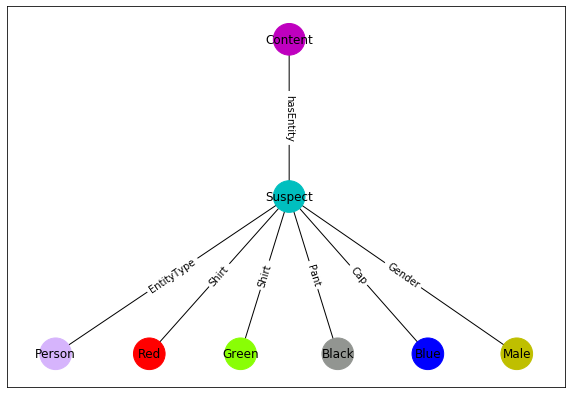

In [52]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout

# G = graphs[rid]
G = nx.DiGraph()
G.add_edges_from(
    [('Content', 'Suspect'), ('Suspect', 'Person'), ('Suspect', 'Red'), ('Suspect', 'Green'), ('Suspect', 'Black'),
     ('Suspect', 'Blue'), ('Suspect', 'Male')])

# val_map = {'Suspect': 1.0,
#            'Content': 0.5714285714285714,
#            'Red': 0.4,
#            'Male': 0.0}
val_map = {}
val_map = {'Red': 'r',
           'Black': '#929591', #'k',
           'Blue': 'b',
           'Green': '#89fe05',
           'Male': 'y',
           'Female': 'y',
           'Suspect': 'c',
           'Content': 'm',
           'Person': '#d6b4fc',
           'Complex': '#ae7181' # mauve
          }

values = [val_map.get(node, 'b') for node in G.nodes()]
print(values)

# Specify the edges you want here
#red_edges = [('Content', 'Suspect'), ('Suspect', 'Person')]
edge_colours = ['black' if not edge in red_edges else 'red'
                for edge in G.edges()]
black_edges = [edge for edge in G.edges() if edge not in red_edges]

# Need to create a layout when doing
# separate calls to draw nodes and edges
pos = nx.spring_layout(G)
pos = nx.bipartite_layout(G, G.nodes())
pos = graphviz_layout(G, prog='dot')
plt.figure(3,figsize=(10,7)) 
nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), 
                       node_color = values, node_size = 1000)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, edgelist=red_edges, edge_color='r', arrows=True)
nx.draw_networkx_edges(G, pos, edgelist=black_edges, arrows=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels={('Content', 'Suspect'):'hasEntity', ('Suspect', 'Person'): 
                                                  'EntityType', ('Suspect', 'Red'):'Shirt', 
                                                  ('Suspect', 'Green'):'Shirt', ('Suspect', 'Black'):'Pant',
                                                  ('Suspect', 'Blue'):'Cap', ('Suspect', 'Male'):'Gender'})

#plt.show()
#plt.figure(figsize=(12, 10))
plt.savefig("distinct1.pdf")
plt.show()

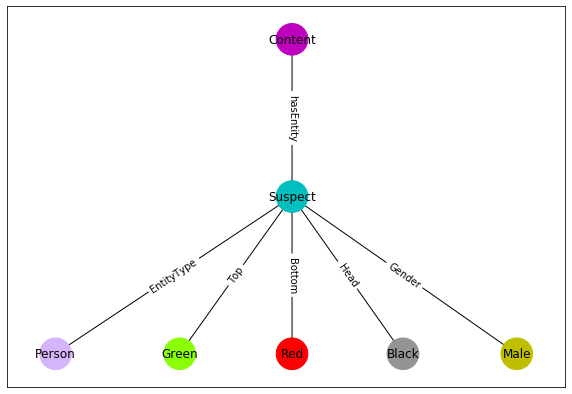

In [50]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout

# G = graphs[rid]
G = nx.DiGraph()
G.add_edges_from(
    [('Content', 'Suspect'), ('Suspect', 'Person'), ('Suspect', 'Green'), ('Suspect', 'Red'),
     ('Suspect', 'Black'), ('Suspect', 'Male')])

# val_map = {'Suspect': 1.0,
#            'Content': 0.5714285714285714,
# #            'Male': 0.0}
# val_map = {}

values = [val_map.get(node, 0.25) for node in G.nodes()]

# Specify the edges you want here
red_edges = []#[('Content', 'Suspect'), ('Suspect', 'Person')]
edge_colours = ['black' if not edge in red_edges else 'red'
                for edge in G.edges()]
black_edges = [edge for edge in G.edges() if edge not in red_edges]

# Need to create a layout when doing
# separate calls to draw nodes and edges
pos = nx.spring_layout(G)
pos = nx.bipartite_layout(G, G.nodes())
pos = graphviz_layout(G, prog='dot')
plt.figure(3,figsize=(10,7)) 
nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), 
                       node_color = values, node_shape = 'o', node_size = 1000)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, edgelist=red_edges, edge_color='r', arrows=True)
nx.draw_networkx_edges(G, pos, edgelist=black_edges, arrows=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels={('Content', 'Suspect'):'hasEntity', ('Suspect', 'Person'): 
                                                  'EntityType', 
                                                  ('Suspect', 'Green'):'Top', ('Suspect', 'Red'):'Bottom',
                                                  ('Suspect', 'Black'):'Head', ('Suspect', 'Male'):'Gender'})


plt.savefig("common1.pdf")
plt.show()

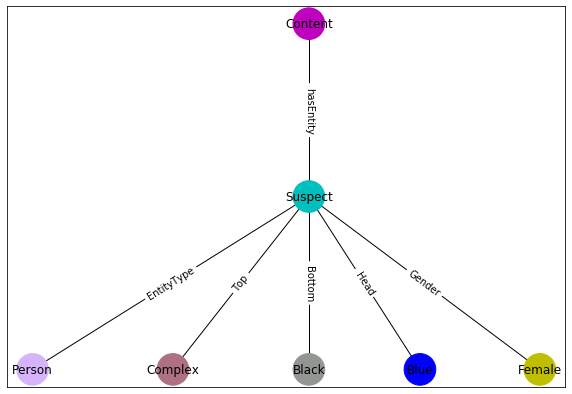

In [51]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout

# G = graphs[rid]
G = nx.DiGraph()
G.add_edges_from(
    [('Content', 'Suspect'), ('Suspect', 'Person'), ('Suspect', 'Complex'), ('Suspect', 'Black'),
     ('Suspect', 'Blue'), ('Suspect', 'Female')])

# val_map = {'Suspect': 1.0,
#            'Content': 0.5714285714285714,
#            'Male': 0.0}
#val_map = {}

values = [val_map.get(node, 0.25) for node in G.nodes()]

# Specify the edges you want here
#red_edges = [('Content', 'Suspect'), ('Suspect', 'Person')]
edge_colours = ['black' if not edge in red_edges else 'red'
                for edge in G.edges()]
black_edges = [edge for edge in G.edges() if edge not in red_edges]

# Need to create a layout when doing
# separate calls to draw nodes and edges
pos = nx.spring_layout(G)
pos = nx.bipartite_layout(G, G.nodes())
pos = graphviz_layout(G, prog='dot')
plt.figure(3,figsize=(10,7)) 
nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), 
                       node_color = values, node_size = 1000)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, edgelist=red_edges, edge_color='r', arrows=True)
nx.draw_networkx_edges(G, pos, edgelist=black_edges, arrows=False)
nx.draw_networkx_edge_labels(G, pos, edge_labels={('Content', 'Suspect'):'hasEntity', ('Suspect', 'Person'): 
                                                  'EntityType', 
                                                  ('Suspect', 'Complex'):'Top', ('Suspect', 'Black'):'Bottom',
                                                  ('Suspect', 'Blue'):'Head', ('Suspect', 'Female'):'Gender'})

plt.savefig("common2.pdf")
plt.show()

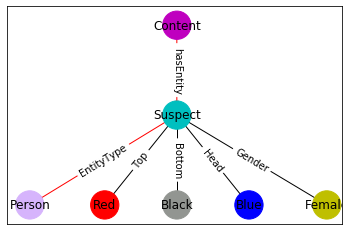

In [73]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout

# G = graphs[rid]
G = nx.DiGraph()
G.add_edges_from(
    [('Content', 'Suspect'), ('Suspect', 'Person'), ('Suspect', 'Red'), ('Suspect', 'Black'),
     ('Suspect', 'Blue'), ('Suspect', 'Female')])

# val_map = {'Suspect': 1.0,
#            'Content': 0.5714285714285714,
#            'Male': 0.0}
#val_map = {}

values = [val_map.get(node, 0.25) for node in G.nodes()]

# Specify the edges you want here
red_edges = [('Content', 'Suspect'), ('Suspect', 'Person')]
edge_colours = ['black' if not edge in red_edges else 'red'
                for edge in G.edges()]
black_edges = [edge for edge in G.edges() if edge not in red_edges]

# Need to create a layout when doing
# separate calls to draw nodes and edges
pos = nx.spring_layout(G)
pos = nx.bipartite_layout(G, G.nodes())
pos = graphviz_layout(G, prog='dot')
nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), 
                       node_color = values, node_size = 800)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, edgelist=red_edges, edge_color='r', arrows=True)
nx.draw_networkx_edges(G, pos, edgelist=black_edges, arrows=False)
nx.draw_networkx_edge_labels(G, pos, edge_labels={('Content', 'Suspect'):'hasEntity', ('Suspect', 'Person'): 
                                                  'EntityType', 
                                                  ('Suspect', 'Red'):'Top', ('Suspect', 'Black'):'Bottom',
                                                  ('Suspect', 'Blue'):'Head', ('Suspect', 'Female'):'Gender'})

plt.show()

In [3]:
# used - test
for k,v in graphs.items():
    # print(graphs[k].nodes(data=True))
    print([item[1]['label'] for item in graphs[k].nodes(data=True)])
    # print(graphs[k].edges(data=True))
    print([[item[0],item[1]] for item in graphs[k].edges(data=True)])

[0, 1, 2, 3, 3, 3]
[[0, 1], [1, 2], [1, 3], [1, 4], [1, 5]]
[0, 1, 2, 3, 3, 3]
[[0, 1], [1, 2], [1, 3], [1, 4], [1, 5]]
[0, 1, 2, 3, 4, 4]
[[0, 1], [1, 2], [1, 3], [1, 4], [1, 5]]
[0, 1, 2, 3, 5, 3]
[[0, 1], [1, 2], [1, 3], [1, 4], [1, 5]]
[0, 1, 2, 3, 6, 6]
[[0, 1], [1, 2], [1, 3], [1, 4], [1, 5]]
[0, 1, 2, 3, 3, 3]
[[0, 1], [1, 2], [1, 3], [1, 4], [1, 5]]
[0, 1, 2, 3, 7, 3]
[[0, 1], [1, 2], [1, 3], [1, 4], [1, 5]]
[0, 1, 2, 3, 3, 3]
[[0, 1], [1, 2], [1, 3], [1, 4], [1, 5]]
[0, 1, 2, 3, 3, 3]
[[0, 1], [1, 2], [1, 3], [1, 4], [1, 5]]
[0, 1, 2, 3, 3, 3]
[[0, 1], [1, 2], [1, 3], [1, 4], [1, 5]]
[0, 1, 2, 3, 3, 3]
[[0, 1], [1, 2], [1, 3], [1, 4], [1, 5]]
[0, 1, 2, 3, 3, 3]
[[0, 1], [1, 2], [1, 3], [1, 4], [1, 5]]
[0, 1, 2, 3, 3, 8]
[[0, 1], [1, 2], [1, 3], [1, 4], [1, 5]]
[0, 1, 2, 3, 8, 3]
[[0, 1], [1, 2], [1, 3], [1, 4], [1, 5]]
[0, 1, 2, 3, 4, 3]
[[0, 1], [1, 2], [1, 3], [1, 4], [1, 5]]
[0, 1, 2, 3, 3, 3]
[[0, 1], [1, 2], [1, 3], [1, 4], [1, 5]]
[0, 1, 2, 3, 3, 3]
[[0, 1], [1, 2], [1, 

[[0, 1], [1, 2], [1, 3], [1, 4], [1, 5]]
[0, 1, 2, 4, 4, 8]
[[0, 1], [1, 2], [1, 3], [1, 4], [1, 5]]
[0, 1, 2, 3, 8, 3]
[[0, 1], [1, 2], [1, 3], [1, 4], [1, 5]]
[0, 1, 2, 3, 8, 3]
[[0, 1], [1, 2], [1, 3], [1, 4], [1, 5]]
[0, 1, 2, 3, 3, 3]
[[0, 1], [1, 2], [1, 3], [1, 4], [1, 5]]
[0, 1, 2, 3, 8, 8]
[[0, 1], [1, 2], [1, 3], [1, 4], [1, 5]]
[0, 1, 2, 3, 3, 5]
[[0, 1], [1, 2], [1, 3], [1, 4], [1, 5]]
[0, 1, 2, 3, 7, 3]
[[0, 1], [1, 2], [1, 3], [1, 4], [1, 5]]
[0, 1, 2, 3, 3, 3]
[[0, 1], [1, 2], [1, 3], [1, 4], [1, 5]]
[0, 1, 2, 3, 3, 7]
[[0, 1], [1, 2], [1, 3], [1, 4], [1, 5]]
[0, 1, 2, 3, 3, 3]
[[0, 1], [1, 2], [1, 3], [1, 4], [1, 5]]
[0, 1, 2, 3, 7, 3]
[[0, 1], [1, 2], [1, 3], [1, 4], [1, 5]]
[0, 1, 2, 3, 3, 8]
[[0, 1], [1, 2], [1, 3], [1, 4], [1, 5]]
[0, 1, 2, 3, 8, 8]
[[0, 1], [1, 2], [1, 3], [1, 4], [1, 5]]
[0, 1, 2, 3, 4, 3]
[[0, 1], [1, 2], [1, 3], [1, 4], [1, 5]]
[0, 1, 2, 3, 3, 3]
[[0, 1], [1, 2], [1, 3], [1, 4], [1, 5]]
[0, 1, 2, 3, 3, 3]
[[0, 1], [1, 2], [1, 3], [1, 4], [1, 5]]

[0, 1, 2, 3, 3, 3]
[[0, 1], [1, 2], [1, 3], [1, 4], [1, 5]]
[0, 1, 2, 3, 8, 3]
[[0, 1], [1, 2], [1, 3], [1, 4], [1, 5]]
[0, 1, 2, 3, 3, 3]
[[0, 1], [1, 2], [1, 3], [1, 4], [1, 5]]
[0, 1, 2, 3, 3, 3]
[[0, 1], [1, 2], [1, 3], [1, 4], [1, 5]]
[0, 1, 2, 3, 3, 3]
[[0, 1], [1, 2], [1, 3], [1, 4], [1, 5]]
[0, 1, 2, 8, 3, 3]
[[0, 1], [1, 2], [1, 3], [1, 4], [1, 5]]
[0, 1, 2, 3, 3, 3]
[[0, 1], [1, 2], [1, 3], [1, 4], [1, 5]]
[0, 1, 2, 3, 4, 3]
[[0, 1], [1, 2], [1, 3], [1, 4], [1, 5]]
[0, 1, 2, 3, 3, 3]
[[0, 1], [1, 2], [1, 3], [1, 4], [1, 5]]
[0, 1, 2, 3, 3, 8]
[[0, 1], [1, 2], [1, 3], [1, 4], [1, 5]]
[0, 1, 2, 3, 3, 3]
[[0, 1], [1, 2], [1, 3], [1, 4], [1, 5]]
[0, 1, 2, 3, 3, 3]
[[0, 1], [1, 2], [1, 3], [1, 4], [1, 5]]
[0, 1, 2, 3, 7, 7]
[[0, 1], [1, 2], [1, 3], [1, 4], [1, 5]]
[0, 1, 2, 3, 3, 3]
[[0, 1], [1, 2], [1, 3], [1, 4], [1, 5]]
[0, 1, 2, 3, 3, 3]
[[0, 1], [1, 2], [1, 3], [1, 4], [1, 5]]
[0, 1, 2, 3, 4, 3]
[[0, 1], [1, 2], [1, 3], [1, 4], [1, 5]]
[0, 1, 2, 3, 3, 3]
[[0, 1], [1, 2], [1, 

[0, 1, 2, 5, 16, 23]
[[0, 1], [1, 2], [1, 3], [1, 4], [1, 5]]
[0, 1, 2, 7, 3, 4, 24]
[[0, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6]]
[0, 1, 2, 9, 8, 23]
[[0, 1], [1, 2], [1, 3], [1, 4], [1, 5]]
[0, 1, 2, 10, 6, 23]
[[0, 1], [1, 2], [1, 3], [1, 4], [1, 5]]
[0, 1, 2, 11, 3, 3, 24]
[[0, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6]]
[0, 1, 2, 4, 10, 23]
[[0, 1], [1, 2], [1, 3], [1, 4], [1, 5]]
[0, 1, 2, 8, 3, 11, 24]
[[0, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6]]
[0, 1, 2, 8, 4, 8, 24]
[[0, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6]]
[0, 1, 2, 6, 10, 11, 24]
[[0, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6]]
[0, 1, 2, 9, 7, 24]
[[0, 1], [1, 2], [1, 3], [1, 4], [1, 5]]
[0, 1, 2, 5, 5, 10, 24]
[[0, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6]]
[0, 1, 2, 10, 8, 24]
[[0, 1], [1, 2], [1, 3], [1, 4], [1, 5]]


In [6]:
# distance problem 
def editDistDP(str1, str2, m, n): 
    #print(str1)
    #print(str2)
    # Create a table to store results of subproblems 
    dp = [[0 for x in range(n + 1)] for x in range(m + 1)] 
  
    # Fill d[][] in bottom up manner 
    for i in range(m + 1): 
        for j in range(n + 1): 
  
            # If first string is empty, only option is to 
            # insert all characters of second string 
            if i == 0: 
                dp[i][j] = j    # Min. operations = j 
  
            # If second string is empty, only option is to 
            # remove all characters of second string 
            elif j == 0: 
                dp[i][j] = i    # Min. operations = i 
  
            # If last characters are same, ignore last char 
            # and recur for remaining string 
            elif str1[i-1] == str2[j-1]: 
                dp[i][j] = dp[i-1][j-1] 
  
            # If last character are different, consider all 
            # possibilities and find minimum 
            else: 
                dp[i][j] = 1 + min(dp[i][j-1],        # Insert 
                                   dp[i-1][j],        # Remove 
                                   dp[i-1][j-1])    # Replace 
  
    return dp[m][n] 
  
# Driver program 
str2 = ['blue', 'R', 'G', 'B']
str1 = 'blue'

print(editDistDP(str1, str2, len(str1), len(str2))) 

4


In [58]:
import math

math.exp(-(4/14))

0.751477293075286